In [27]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit

%matplotlib inline

label_encoder = preprocessing.LabelEncoder()

In [50]:
data1 = pd.read_csv("data/phishing_websites.csv").astype('category')
data2 = pd.read_csv("data/online_shoppers_intention.csv")
data1.drop(['id'], axis=1, inplace=True)


### phishing data preprocessing

In [51]:
col_to_one_hot = []
for i, col in enumerate(data1):
    # print(col, data1[col].unique())
    if data1[col].unique().size > 2:
        col_to_one_hot.append(col)
df_one_hot = data1[col_to_one_hot]
df_one_hot = pd.get_dummies(df_one_hot)
df_other = data1.drop(col_to_one_hot, axis=1)
data1 = pd.concat([df_one_hot, df_other], axis=1)
data1.head()
data1.describe(include='all')
X1 = data1.drop(['Result'], axis=1)
Y1 = data1[['Result']]
print(X1.shape)
print(Y1.shape)

(11055, 46)
(11055, 1)



### online shopper data preprocessing

In [52]:
columns_to_encode = ['Month', 'VisitorType','Weekend','Revenue']
label_encoder = preprocessing.LabelEncoder()
df = data2[columns_to_encode]
df = df.apply(label_encoder.fit_transform)
data2 = data2.drop(columns_to_encode, axis=1)
data2 = pd.concat([data2, df], axis=1)
data2.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Month,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,2,2,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,2,2,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,2,2,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,2,2,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,2,2,1,0


In [53]:
# data2['ProductRelated_Duration'].hist(bins=4)
data2.describe(include='all')
# data2['OperatingSystems'].value_counts()
# data21 = pd.get_dummies(data2)
# data21.describe(include='all')
# data21.columns
# X2 = data21.drop(['Revenue'], axis=1)
# Y2 = data21[['Revenue']]
X2 = data2.drop(['Revenue'], axis=1)
Y2 = data2[['Revenue']]
print(X2.shape)
print(Y2.shape)

(12330, 17)
(12330, 1)


### plots

In [54]:
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        # X_subset = X[idx,:]
        # y_subset = y[idx]
        X_subset = X.iloc[idx, :]
        y_subset = y.iloc[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_mean, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


### ML code

In [62]:
from sklearn.neighbors import KNeighborsClassifier as kNN
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,test_size=0.2, shuffle=True)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,test_size=0.2, shuffle=True)
def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    # klist = np.linspace(1,250,25).astype('int')
    klist = np.linspace(1,50,50).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,
                  n_jobs=-1, 
                  algorithm='auto',
                  p=2
                  )
        # print(X_train.shape, y_train.shape)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8844, 1)
(8844, 46) (8

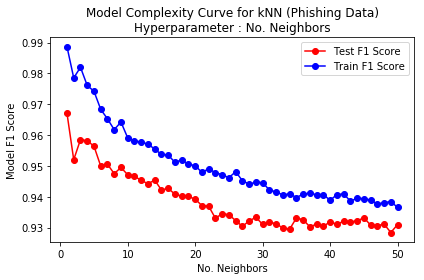

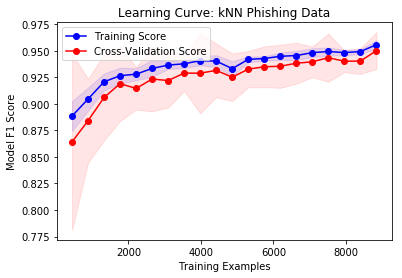

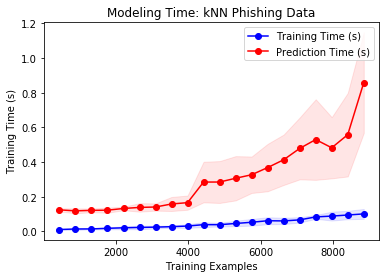

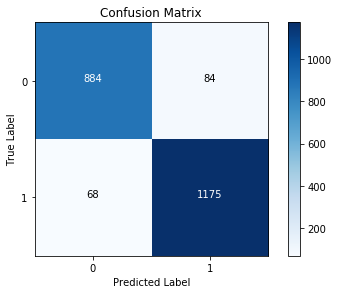

In [61]:
estimator_phish = kNN(n_neighbors=20, n_jobs=-1)
hyperKNN(X1_train, Y1_train,X1_test, Y1_test, title="Model Complexity Curve for kNN (Phishing Data)\nHyperparameter : No. Neighbors")
train_samp_phish, kNN_train_score_phish, kNN_fit_time_phish, kNN_pred_time_phish = plot_learning_curve(estimator_phish, X1_train, Y1_train,title="kNN Phishing Data")
final_classifier_evaluation(estimator_phish, X1_train, X1_test, Y1_train, Y1_test)





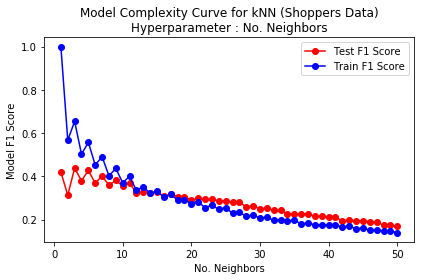

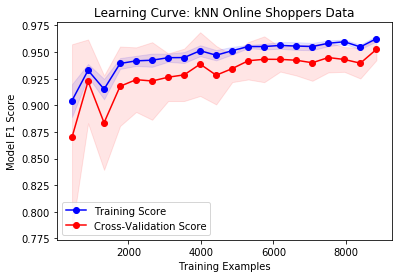

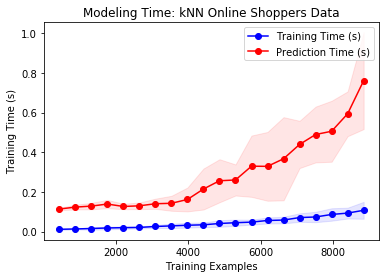

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.02440
Model Prediction Time (s): 0.15620

F1 Score:  0.36
Accuracy:  0.87     AUC:       0.61
Precision: 0.77     Recall:    0.23
*****************************************************


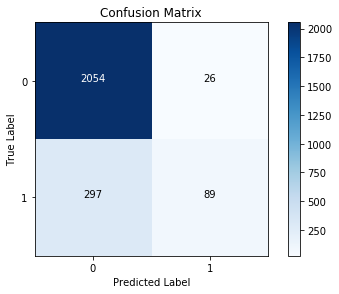

In [63]:
estimator_online_shoppers = kNN(n_neighbors=10, n_jobs=-1)
hyperKNN(X2_train, Y2_train, X2_test, Y2_test, title="Model Complexity Curve for kNN (Shoppers Data)\nHyperparameter : No. Neighbors")
train_samp_phish, kNN_train_score_phish, kNN_fit_time_phish, kNN_pred_time_phish = plot_learning_curve(estimator_online_shoppers, X1_train, Y1_train,title="kNN Online Shoppers Data")
final_classifier_evaluation(estimator_online_shoppers, X2_train, X2_test, Y2_train, Y2_test)




### decision tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=10)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']


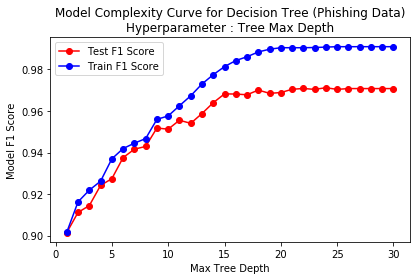

Per Hyperparameter tuning, best parameters are:
{'max_depth': 9, 'min_samples_leaf': 44}
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.02404
Model Prediction Time (s): 0.00499

F1 Score:  0.93
Accuracy:  0.92     AUC:       0.92
Precision: 0.93     Recall:    0.93
*****************************************************


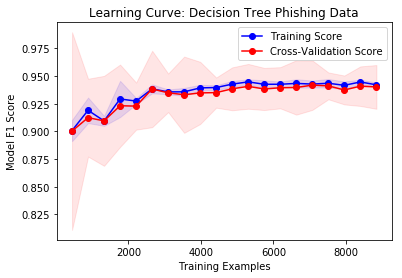

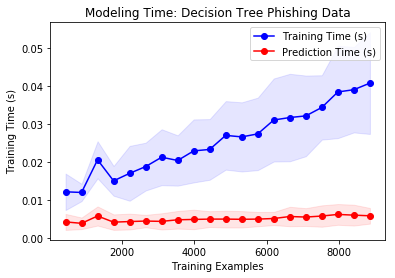

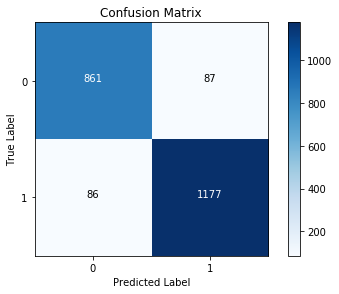

In [66]:
hyperTree(X1_train, Y1_train, X1_test, Y1_test,title="Model Complexity Curve for Decision Tree (Phishing Data)\nHyperparameter : Tree Max Depth")

start_leaf_n = round(0.005*len(X1_train))
end_leaf_n = round(0.05*len(X1_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X1_train,Y1_train)
estimator_phish = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
train_samp_phish, DT_train_score_phish, DT_fit_time_phish, DT_pred_time_phish = plot_learning_curve(estimator_phish, X1_train, Y1_train,title="Decision Tree Phishing Data")
final_classifier_evaluation(estimator_phish, X1_train, X1_test, Y1_train, Y1_test)

In [ ]:
hyperTree(X2_train, Y2_train, X2_test, Y2_test,title="Model Complexity Curve for Decision Tree (Phishing Data)\nHyperparameter : Tree Max Depth")

start_leaf_n = round(0.005*len(X2_train))
end_leaf_n = round(0.05*len(X2_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X2_train,Y2_train)
estimator_phish = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')
train_samp_phish, DT_train_score_phish, DT_fit_time_phish, DT_pred_time_phish = plot_learning_curve(estimator_phish, X2_train, Y2_train,title="Decision Tree Phishing Data")
final_classifier_evaluation(estimator_phish, X2_train, X2_test, Y2_train, Y2_test)

